# Convolutional Neural Network for identifying cats and dogs

Using device: cuda
Epoch 1/25, Loss: 0.6885, Accuracy: 54.89%, Val Loss: 0.6755, Val Accuracy: 58.50%
Epoch 2/25, Loss: 0.6716, Accuracy: 58.11%, Val Loss: 0.6526, Val Accuracy: 60.20%
Epoch 3/25, Loss: 0.6278, Accuracy: 64.44%, Val Loss: 0.6022, Val Accuracy: 69.50%
Epoch 4/25, Loss: 0.5793, Accuracy: 69.49%, Val Loss: 0.5628, Val Accuracy: 70.55%
Epoch 5/25, Loss: 0.5587, Accuracy: 70.95%, Val Loss: 0.5467, Val Accuracy: 72.65%
Epoch 6/25, Loss: 0.5315, Accuracy: 72.86%, Val Loss: 0.5423, Val Accuracy: 73.55%
Epoch 7/25, Loss: 0.5201, Accuracy: 74.01%, Val Loss: 0.5376, Val Accuracy: 73.90%
Epoch 8/25, Loss: 0.5087, Accuracy: 74.79%, Val Loss: 0.5356, Val Accuracy: 73.60%
Epoch 9/25, Loss: 0.4964, Accuracy: 75.55%, Val Loss: 0.5223, Val Accuracy: 75.55%
Epoch 10/25, Loss: 0.4907, Accuracy: 76.35%, Val Loss: 0.5015, Val Accuracy: 75.90%
Epoch 11/25, Loss: 0.4723, Accuracy: 76.84%, Val Loss: 0.5249, Val Accuracy: 74.65%
Epoch 12/25, Loss: 0.4701, Accuracy: 77.24%, Val Loss: 0.5147, Val

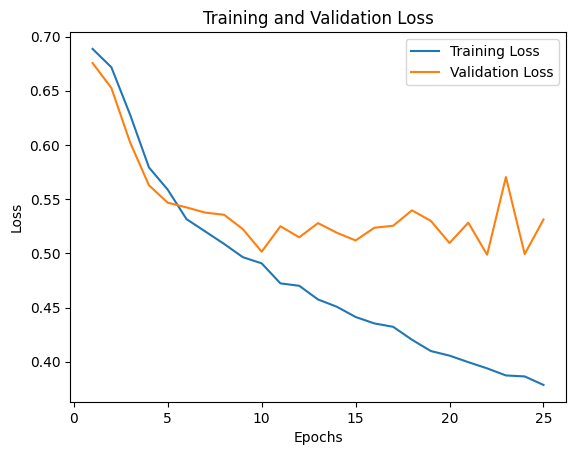

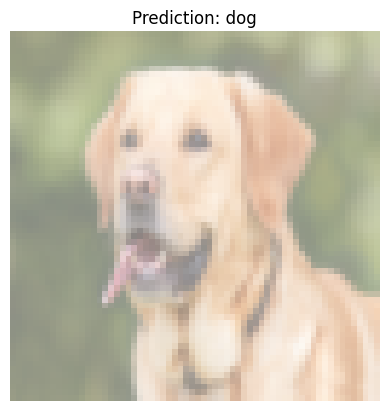

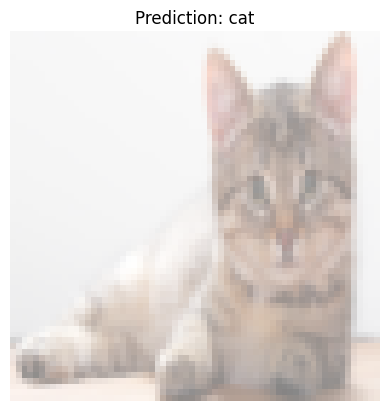

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pickle
import os

# Create output directory if it does not exist
os.makedirs('outputs', exist_ok=True)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Data Preprocessing
# Transformations for training and test sets
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(64, scale=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0])  # Normalize to [0, 1]
])

test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0])  # Normalize to [0, 1]
])

# Load datasets
train_dataset = datasets.ImageFolder(root='raw_data/training_set', transform=train_transform)
test_dataset = datasets.ImageFolder(root='raw_data/test_set', transform=test_transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Building the CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 32 * 16 * 16)
        x = torch.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

# Instantiate the model, define the loss function and the optimizer
model = CNN().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the CNN
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=25):
    train_losses, val_losses = [], []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)  # Adjust labels shape for BCELoss
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_accuracy = 100 * correct / total
        train_losses.append(running_loss / len(train_loader))

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                labels = labels.float().unsqueeze(1)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                predicted = (outputs > 0.5).float()
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        val_accuracy = 100 * val_correct / val_total
        val_losses.append(val_loss / len(test_loader))

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss/len(test_loader):.4f}, Val Accuracy: {val_accuracy:.2f}%")

    # Save the model weights to a .pkl file
    with open('cnn_model_weights.pkl', 'wb') as f:
        pickle.dump(model.state_dict(), f)

    # Plot and save the training and validation loss
    plt.figure()
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.savefig('outputs/training_validation_loss.png')
    plt.show()

train_model(model, train_loader, test_loader, criterion, optimizer)

# Load model weights for later use
def load_model_weights(model, weights_path):
    with open(weights_path, 'rb') as f:
        model.load_state_dict(pickle.load(f))

# Predicting on a single image
def predict_image(model, image_path):
    model.eval()
    img = Image.open(image_path)
    img = test_transform(img)
    img = img.unsqueeze(0).to(device)  # Add batch dimension and move to device
    with torch.no_grad():
        output = model(img)
        prediction = 'dog' if output.item() > 0.5 else 'cat'
    return prediction, img.cpu()

# Load and predict images 'cat_or_dog_1.jpg' and 'cat_or_dog_2.jpg'
images = ['raw_data/single_prediction/cat_or_dog_1.jpg', 'raw_data/single_prediction/cat_or_dog_2.jpg']

# Load model weights before prediction (if needed)
load_model_weights(model, 'cnn_model_weights.pkl')
model.to(device)

for image_path in images:
    prediction, img_tensor = predict_image(model, image_path)
    # Convert tensor to image for plotting
    img_np = img_tensor.squeeze().permute(1, 2, 0).numpy()
    img_np = (img_np * 0.5) + 0.5  # Denormalize
    plt.imshow(img_np)
    plt.title(f'Prediction: {prediction}')
    plt.axis('off')
    plt.savefig(f'outputs/{os.path.basename(image_path).split('.')[0]}_prediction.png')
    plt.show()